# Speed Dating 

### Cleanning data 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

In [2]:
import sklearn as sk
import sklearn.tree as tree
import sklearn.preprocessing as pp
import sklearn.metrics as sm
import sklearn.feature_selection as fs
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

In [3]:
data = pd.read_csv('Speed Dating Data.csv',encoding="ISO-8859-1").rename(columns=lambda x: x.strip())
sd_org=data.copy()

In [4]:
# select waves 1 -14
sd = sd_org[sd_org['wave']< 15]

In [5]:
# convert income to numeric values
sd['income'] = sd['income'].str.replace(',', '')
sd['income']= pd.to_numeric(sd['income'])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Drop those colunms for 'half way through' period 
sd= sd.drop(['attr1_s', 'sinc1_s', 'intel1_s', 'fun1_s', 'amb1_s', 'shar1_s',
             'attr3_s', 'sinc3_s', 'intel3_s', 'fun3_s', 'amb3_s'],axis=1)

In [7]:
# Drop those colunms for 'follow-up 2' period, becuase these were filled out after 3-4 
# weeks after the event. A lot of them were NaN values and we think that participants 
# might not remember very clearly by that time. 

sd= sd.drop(['attr1_3', 'sinc1_3', 'intel1_3', 'fun1_3', 'amb1_3', 'shar1_3',
             'attr2_3', 'sinc2_3', 'intel2_3', 'fun2_3', 'amb2_3', 'shar2_3',
             'attr3_3', 'sinc3_3', 'intel3_3', 'fun3_3', 'amb3_3',
             'attr4_3', 'sinc4_3', 'intel4_3', 'fun4_3', 'amb4_3', 'shar4_3',
             'attr5_3', 'sinc5_3', 'intel5_3', 'fun5_3', 'amb5_3', 
             'attr7_3', 'sinc7_3', 'intel7_3', 'fun7_3', 'amb7_3', 'shar7_3',],axis=1)

In [8]:
# Drop attr7_2, because it doesn't pair up with the question asked in the correspoding sign up period.
sd= sd.drop('attr7_2',axis=1)

In [9]:
# Drop those columns that won't be used in this analysis 
sd= sd.drop(['id', 'idg', 'wave','round','condtn', 'position', 'positin1','partner','pid','int_corr',
             'age_o','race_o','from','zipcode','career','career_c','satis_2','length',
             'pf_o_att','pf_o_sin','pf_o_int','pf_o_fun','pf_o_amb','pf_o_sha','field',
             'undergra','mn_sat','tuition','exphappy','expnum','numdat_2','samerace',
             'match_es','you_call','them_cal','date_3','numdat_3','num_in_3'],axis=1)

In [10]:
# group those attributes suing 1-10 scales
ten = ['attr3_1', 'sinc3_1',
       'fun3_1', 'intel3_1', 'amb3_1', 'attr5_1', 'sinc5_1', 'intel5_1',
       'fun5_1', 'amb5_1','attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2',
       'attr5_2', 'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2']

# group those attributes using 100 point system
hrd = ['attr1_1', 'sinc1_1',
       'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1', 'attr4_1', 'sinc4_1',
       'intel4_1', 'fun4_1', 'amb4_1', 'shar4_1', 'attr2_1', 'sinc2_1',
       'intel2_1', 'fun2_1', 'amb2_1', 'shar2_1','sinc7_2', 'intel7_2', 'fun7_2', 'amb7_2',
       'shar7_2', 'attr1_2', 'sinc1_2', 'intel1_2', 'fun1_2', 'amb1_2',
       'shar1_2', 'attr4_2', 'sinc4_2', 'intel4_2', 'fun4_2', 'amb4_2',
       'shar4_2', 'attr2_2', 'sinc2_2', 'intel2_2', 'fun2_2', 'amb2_2',
       'shar2_2']

In [11]:
# Normalize two different scales 

# Normalize 10 point scale
sd[ten]=sd[ten].apply(lambda x: ((x-1)/9))

# Normalize 100 point scale
sd[hrd]=sd[hrd].apply(lambda x: x/100)

In [12]:
# final columns to keep 
sd.columns

Index(['iid', 'gender', 'order', 'match', 'dec_o', 'attr_o', 'sinc_o',
       'intel_o', 'fun_o', 'amb_o',
       ...
       'attr3_2', 'sinc3_2', 'intel3_2', 'fun3_2', 'amb3_2', 'attr5_2',
       'sinc5_2', 'intel5_2', 'fun5_2', 'amb5_2'],
      dtype='object', length=111)

### Descriptive Analysis 

### Clustering


We wanted to classify match/no match based on participants' interests and character attributes from the sign up period. Our initial approach was to check the correlations amoung these variables and drop one variable in pairs with high correlations 

In [13]:
# features we want to include in our analysis for sign up period
features =['gender','match','round','order','age','field_cd','race','imprace','imprelig','date','go_out',
           'sports','tvsports','exercise','dining','museums','art','hiking','gaming',
           'clubbing','reading','tv','theater','movies','music','shopping','yoga',
           'attr1_1', 'sinc1_1', 'intel1_1', 'fun1_1', 'amb1_1', 'shar1_1',
           'attr2_1', 'sinc2_1','intel2_1', 'fun2_1', 'amb2_1', 'shar2_1', 'attr3_1',
           'sinc3_1','fun3_1', 'intel3_1', 'amb3_1']

In [14]:
# correlations between features
sd[features].corr().head()

KeyError: "['round'] not in index"

In [ ]:
# heatmap of the correlations
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[features].corr(),linewidths=.5, ax=ax)

In [ ]:
# drop one feature in the pairs that have high correlation
keep =['gender','match','order','age','field_cd','race','imprace','income','date',
       'exercise','museums','hiking','gaming','clubbing','reading','tv','music','yoga',
       'sinc1_1', 'intel1_1','fun1_1', 'amb1_1', 'shar1_1','intel2_1', 'fun2_1',
       'sinc3_1','fun3_1', 'intel3_1']

In [ ]:
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(sd[keep].corr(),linewidths=.5, ax=ax)

In [ ]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from sklearn.cluster import AgglomerativeClustering

bestSil = -1
for k in range(2,6):
    clus = [KMeans(n_clusters=k,n_jobs=-1), Birch(n_clusters=k), 
            AgglomerativeClustering(n_clusters=k)]
    for cl in clus:
        res = cl.fit(temp1)
        sil = metrics.silhouette_score(temp1, res.labels_)
        print (str(cl)[:10] + ' with k =' +str(k) + ": " + str(round(sil,4)))
        if (sil > bestSil):
            bestSil = sil
            bestCl = cl

In [ ]:
kmeans = KMeans(n_clusters=4)

In [ ]:
cluster = kmeans.fit_predict(temp1)

In [ ]:
temp1['cluster']=cluster

In [ ]:
temp1.groupby('cluster').mean()

### Classification

In [15]:
# select interests
interest = ['dec_o','sports','tvsports','exercise','dining','museums','art','hiking',
            'gaming','clubbing','reading','tv','theater','movies','music','shopping',
            'yoga']

Classification over interest on major race group: European/Caucasian-American

In [16]:
# include waves 1-14
# Majority group & interest 
wave_m_i = sd[sd['race']==2].loc[:, interest]

In [17]:
len(wave_m_i)
wave_m_i.isnull().sum()

3236

dec_o        0
sports      16
tvsports    16
exercise    16
dining      16
museums     16
art         16
hiking      16
gaming      16
clubbing    16
reading     16
tv          16
theater     16
movies      16
music       16
shopping    16
yoga        16
dtype: int64

In [18]:
# drop nan value
wave_m_i=wave_m_i.dropna(axis=0, how='any')

X_m_i, y_m_i = wave_m_i.drop(['dec_o'], axis=1), wave_m_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_m_i, y_m_i)

names = X_m_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x10b4178c8>)

  Feat_names   F_Scores
0   exercise  29.087465
2   clubbing  23.211395
1     dining  17.562699
3    reading   8.704325
4   shopping   8.145201


In [19]:
# Random Forest 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X_m_i, y_m_i)
roc_auc_score(y_m_i,model.oob_prediction_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

0.71278378518991126

In [20]:
feature_importances = pd.Series(model.feature_importances_, index = X_m_i.columns)
feature_importances.sort_values(inplace=True)

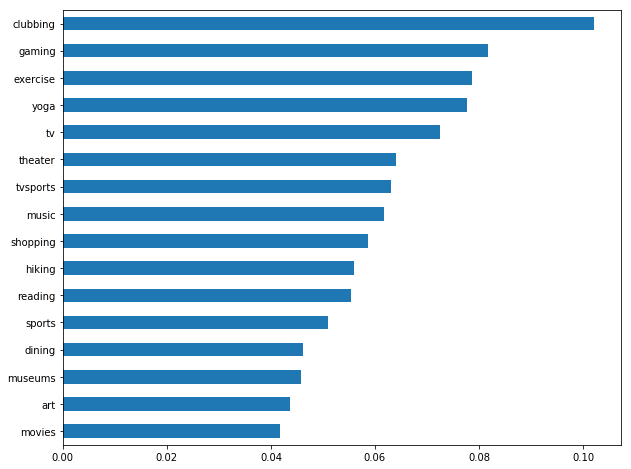

In [21]:
feature_importances.plot(kind='barh', figsize=(10,8))

In [22]:
# best 
interest_best = ['dec_o','dining','clubbing','shopping','exercise','reading']
#interest_best = ['dec_o','yoga','clubbing','gaming','exercise','tv']
wave6_m_i = sd[sd['race']==2].loc[:, interest_best]

In [23]:
wave6_m_i=wave6_m_i.dropna(axis=0, how='any')
wave6_m_i.isnull().sum()
len(wave6_m_i[wave6_m_i['dec_o']==1])
len(wave6_m_i[wave6_m_i['dec_o']==0])

dec_o       0
dining      0
clubbing    0
shopping    0
exercise    0
reading     0
dtype: int64

1421

1799

In [24]:
X_m_i, y_m_i = wave6_m_i.drop(['dec_o'], axis=1), wave6_m_i['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_i, y_m_i)
dtc_labels = dtc.predict(X_m_i)
dtc_labels

array([1, 1, 1, ..., 0, 0, 0])

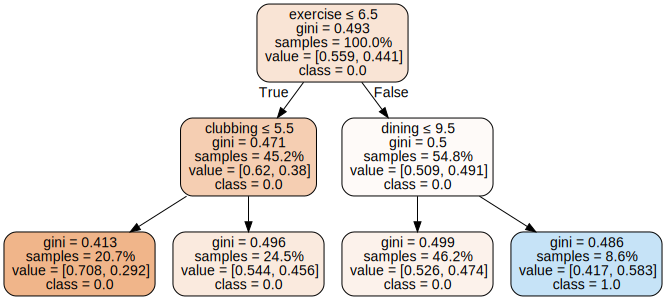

In [25]:
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_i.columns),  
                        #class_names = ['1.0' if i == 1 else '0.0' for i in y.unique()] ,
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

Classification over interest on minor race group: European/Caucasian-American

In [26]:
wave_n_i = sd[(sd['race']==1)|(sd['race']==5)].loc[:, interest]

In [27]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')

X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_n_i, y_n_i)

names = X_n_i.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x10b4178c8>)

  Feat_names   F_Scores
2     hiking  32.002426
0    museums  20.829335
4       yoga  20.387507
1        art  19.893374
3    theater  12.018080


In [28]:
interest_best = ['dec_o','hiking','museums','art','theater','yoga']
wave_n_i = sd[(sd['race']==1)|(sd['race']==5)].loc[:, interest_best]

In [29]:
wave_n_i=wave_n_i.dropna(axis=0, how='any')
wave_n_i.isnull().sum()
len(wave_n_i[wave_n_i['dec_o']==1])
len(wave_n_i[wave_n_i['dec_o']==0])

dec_o      0
hiking     0
museums    0
art        0
theater    0
yoga       0
dtype: int64

129

181

In [30]:
X_n_i, y_n_i = wave_n_i.drop(['dec_o'], axis=1), wave_n_i['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_i, y_n_i)
dtc_labels = dtc.predict(X_n_i)
dtc_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0,

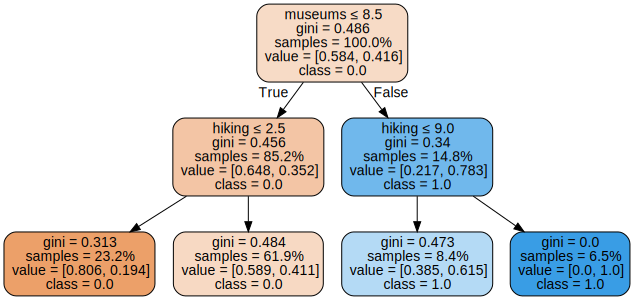

In [31]:
import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_i.columns),  
                        #class_names = ['1.0' if i == 1 else '0.0' for i in y.unique()] ,
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

# --------------------------------------------------------------------

In [32]:
attributes=['dec_o','gender','attr_o', 'sinc_o', 'intel_o','fun_o', 
            'amb_o', 'shar_o','prob_o','met_o']

In [33]:
wave_m_a = sd[sd['race']==2].loc[:, attributes]
len(wave_m_a)
wave_m_a.isnull().sum()

3236

dec_o        0
gender       0
attr_o      59
sinc_o      96
intel_o    103
fun_o      123
amb_o      272
shar_o     403
prob_o     104
met_o      131
dtype: int64

In [34]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')


In [35]:
X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

kb = fs.SelectKBest(k=5)
kb.fit(X_m_a, y_m_a)

names = X_m_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x10b4178c8>)

  Feat_names    F_Scores
0     attr_o  928.302977
2      fun_o  672.504795
3     shar_o  578.232503
4     prob_o  343.995135
1     sinc_o  193.838583


In [36]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
wave_m_a = sd[sd['race']==2].loc[:, attributes_best]
wave_m_a.isnull().sum()

dec_o       0
attr_o     59
fun_o     123
shar_o    403
prob_o    104
dtype: int64

In [37]:
wave_m_a=wave_m_a.dropna(axis=0, how='any')
wave_m_a.head()

,dec_o,attr_o,fun_o,shar_o,prob_o
10,0,8.0,9.0,4.0,2.0
11,0,7.0,6.0,5.0,4.0
12,1,10.0,10.0,10.0,10.0
13,1,9.0,9.0,9.0,7.0
14,1,10.0,10.0,8.0,1.0


dec_o     0
attr_o    0
fun_o     0
shar_o    0
prob_o    0
dtype: int64

1271

1509

array([0, 1, 1, ..., 0, 1, 0])

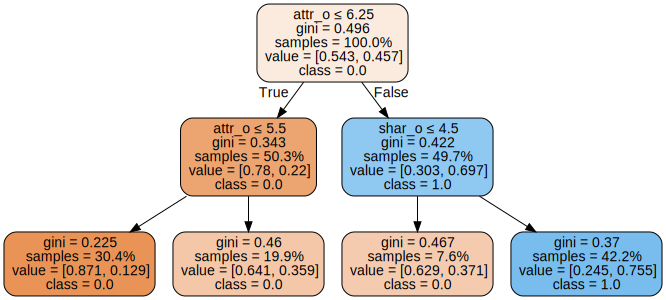

In [38]:
wave_m_a.isnull().sum()
len(wave_m_a[wave_m_a['dec_o']==1])
len(wave_m_a[wave_m_a['dec_o']==0])

X_m_a, y_m_a = wave_m_a.drop(['dec_o'], axis=1), wave_m_a['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_m_a, y_m_a)
dtc_labels = dtc.predict(X_m_a)
dtc_labels

import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_m_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

In [39]:
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes]

In [40]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')

X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

In [41]:
kb = fs.SelectKBest(k=5)
kb.fit(X_n_a, y_n_a)

names = X_n_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

SelectKBest(k=5, score_func=<function f_classif at 0x10b4178c8>)

  Feat_names   F_Scores
0     attr_o  56.977138
3     shar_o  53.763641
1      fun_o  50.393934
4     prob_o  31.619309
2      amb_o  14.992479


In [42]:
attributes_best = ['dec_o','attr_o','fun_o', 'shar_o','prob_o']
wave_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes_best]

In [43]:
wave_n_a=wave_n_a.dropna(axis=0, how='any')
wave_n_a.isnull().sum()
len(wave_n_a[wave_n_a['dec_o']==1])
len(wave_n_a[wave_n_a['dec_o']==0])

dec_o     0
attr_o    0
fun_o     0
shar_o    0
prob_o    0
dtype: int64

114

159

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

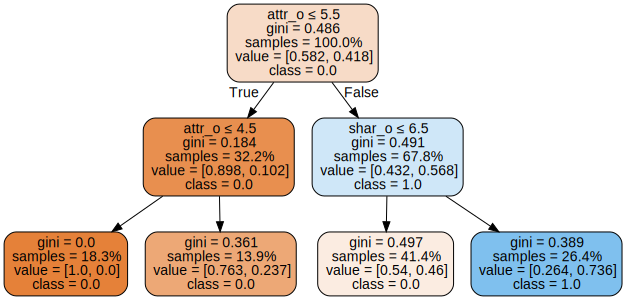

In [44]:
X_n_a, y_n_a = wave_n_a.drop(['dec_o'], axis=1), wave_n_a['dec_o']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X_n_a, y_n_a)
dtc_labels = dtc.predict(X_n_a)
dtc_labels

import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X_n_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

# -----------------------------------------------------------------

In [ ]:
attributes1=['dec','gender','attr', 'sinc', 'intel','fun', 
            'amb', 'shar','prob','met']

In [ ]:
wave1_m_a = sd[sd['race']==2].loc[:, attributes1]
len(wave1_m_a)
wave1_m_a.isnull().sum()
wave1_m_a=wave1_m_a.dropna(axis=0, how='any')
X1_m_a, y1_m_a = wave1_m_a.drop(['dec'], axis=1), wave1_m_a['dec']

kb = fs.SelectKBest(k=5)
kb.fit(X1_m_a, y1_m_a)

names = X1_m_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

In [ ]:
attributes_best = ['dec','attr','fun', 'shar','prob']
wave1_m_a = sd[sd['race']==2].loc[:, attributes_best]
wave1_m_a.isnull().sum()
wave1_m_a=wave1_m_a.dropna(axis=0, how='any')

wave1_m_a.isnull().sum()
len(wave1_m_a[wave1_m_a['dec']==1])
len(wave1_m_a[wave1_m_a['dec']==0])

X1_m_a, y1_m_a = wave1_m_a.drop(['dec'], axis=1), wave1_m_a['dec']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X1_m_a, y1_m_a)

import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X1_m_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

In [ ]:
wave1_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes1]
len(wave1_n_a)
wave1_n_a.isnull().sum()
wave1_n_a=wave1_n_a.dropna(axis=0, how='any')
X1_n_a, y1_n_a = wave1_n_a.drop(['dec'], axis=1), wave1_n_a['dec']

kb = fs.SelectKBest(k=5)
kb.fit(X1_n_a, y1_n_a)

names = X1_n_a.columns.values[kb.get_support()]
scores = kb.scores_[kb.get_support()]
names_scores = list(zip(names, scores))
ns_df = pd.DataFrame(data = names_scores, columns=['Feat_names', 'F_Scores'])
#Sort the dataframe for better visualization
ns_df_sorted = ns_df.sort_values(['F_Scores', 'Feat_names'], ascending = [False, True])
print(ns_df_sorted)

In [ ]:
attributes_best = ['dec','attr','fun', 'shar','prob']
wave1_n_a = sd[(sd['race']==1)|(sd['race']==5)].loc[:, attributes_best]
wave1_n_a.isnull().sum()
wave1_n_a=wave1_n_a.dropna(axis=0, how='any')

wave1_n_a.isnull().sum()
len(wave1_n_a[wave1_n_a['dec']==1])
len(wave1_n_a[wave1_n_a['dec']==0])

X1_n_a, y1_n_a = wave1_n_a.drop(['dec'], axis=1), wave1_n_a['dec']

dtc = tree.DecisionTreeClassifier(max_depth=2).fit(X1_n_a, y1_n_a)

import graphviz
dot_data = sk.tree.export_graphviz(dtc, out_file=None, 
                         feature_names=list(X1_n_a.columns),  
                         class_names = ['1.0' if i == 1 else '0.0' for i in dtc.classes_] ,
                        #class_names =[i for i in temp1['match'].unique()],
                         filled=True, rounded=True,  
                         special_characters=True, 
                         proportion=True,
                        )  
graph = graphviz.Source(dot_data)  
graph

In [ ]:
sns.distplot(sd['sports'].dropna())

In [ ]:
sns.distplot(sd['exercise'].dropna())